In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [4]:
data_list = []
for f in os.listdir("data2"):
    if f.endswith(".csv"):
        data_list.append(pd.read_csv(os.path.join("data2", f)).rename(columns={'Unnamed: 0': 'carpark_id'}))
df = pd.concat(data_list)

In [5]:
df.update_datetime = pd.to_datetime(df["update_datetime"])
df["hour"] = df.update_datetime.dt.hour
df.lots_available = df.lots_available.astype(int)
df.day = df.day.astype(int)
df.carpark_id = df.carpark_id.astype(int)
df = df.drop(["total_lots"], axis=1)
df = df.drop(["update_datetime"], axis=1)
df = df.drop(["carpark_id"], axis=1)
df = df[["carpark_number", "day", "hour", "lots_available"]].sample(frac=0.3)
df = df.reset_index(drop=True)

In [6]:
column_names = ["lots_available", "carpark_number", "day", "hour"]

raw_dataset = df[column_names]

dataset = raw_dataset.copy()
dataset.tail()

,lots_available,carpark_number,day,hour
397605,58,UBK5,2,6
397606,82,PM18,4,17
397607,180,KM2,6,2
397608,154,W100,1,10
397609,126,J9,2,16


In [7]:
carpark_num = dataset.pop('carpark_number')
for num in set(carpark_num):
    dataset[num] = (carpark_num == num)*1.0

In [26]:
features_df = pd.DataFrame(["day", "hour"], columns=["features"])
features_df = features_df.append(pd.DataFrame(set(carpark_num), columns=["features"])).reset_index(drop=True)

In [27]:
features_df.to_csv("features.csv")

In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("lots_available")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
day,318088.0,2.794318,1.926795,0.0,1.0,3.0,4.0,6.0
hour,318088.0,11.958464,6.575647,0.0,6.0,12.0,18.0,23.0
T58,318088.0,0.000534,0.023112,0.0,0.0,0.0,0.0,1.0
TP52,318088.0,0.000509,0.022562,0.0,0.0,0.0,0.0,1.0
TPME,318088.0,0.000497,0.022282,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
KB12,318088.0,0.000412,0.020290,0.0,0.0,0.0,0.0,1.0
SK51,318088.0,0.000541,0.023247,0.0,0.0,0.0,0.0,1.0
PL60,318088.0,0.000472,0.021711,0.0,0.0,0.0,0.0,1.0
Y74M,318088.0,0.000553,0.023516,0.0,0.0,0.0,0.0,1.0


In [12]:
train_labels = train_dataset.pop('lots_available')
test_labels = test_dataset.pop('lots_available')

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.1)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                123264    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 127,489
Trainable params: 127,489
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Display training progress by printing a single dot for each completed epoch
class PrintLoss(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 5 == 0: print(epoch, logs["loss"])

EPOCHS = 20

In [ ]:
history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintLoss()])

0 28204.953125
5 6182.18896484375
10 5595.0712890625
15 5449.37646484375


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
15,5449.376465,31.024380,5449.376465,3252.303711,38.055347,3252.303711,15
16,5415.919434,30.836464,5415.919434,2521.967285,28.573288,2521.967285,16
17,5404.065918,30.756989,5404.065918,2346.995850,28.926802,2346.995850,17
18,5378.427246,30.517389,5378.427246,2421.631348,28.853821,2421.631348,18
19,5360.405273,30.271727,5360.405273,2232.346924,27.522488,2232.346924,19


In [20]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


# plot_history(history)

0 15801.4990234375
5 5667.86572265625
10 5586.62353515625
15 5503.1669921875


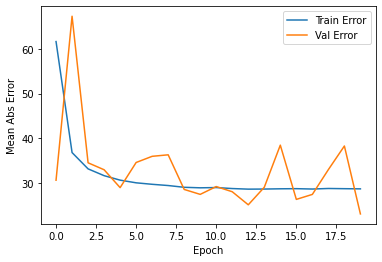

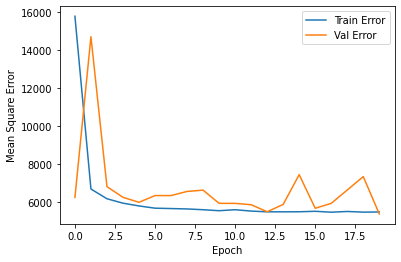

In [21]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintLoss()])

plot_history(history)

In [22]:
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} lots".format(mae))

Testing set Mean Abs Error: 23.00 lots


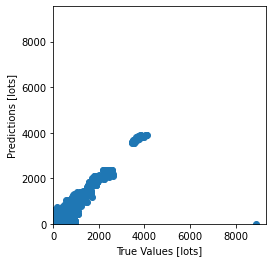

In [23]:
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [lots]')
plt.ylabel('Predictions [lots]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [24]:
model.save("HnR2021_tf_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: HnR2021_tf_model\assets


In [25]:
converter = tf.lite.TFLiteConverter.from_saved_model("HnR2021_tf_model")
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)